# Import libraries

In [1]:
from datetime import datetime, timedelta
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import seaborn as sns

import fastf1

from models import *

fastf1.Cache.enable_cache('C:/Files/Desktop/Education/Purdue/Year-1/Fall-2024/Subjects/CS573 Data Mining/Final Project/workspace/venv')

In [2]:
def get_personal_best_laps(df, column_rank, new_column_name):
    personal_best_laps = df[df['Deleted'] == False].groupby('Driver', as_index=False)[column_rank].min()
    
    personal_best_laps_ranked = personal_best_laps.sort_values(by=column_rank, ascending=True)
    personal_best_laps_ranked[new_column_name] = personal_best_laps_ranked[column_rank].rank(method='dense').fillna(-1).astype(int)
    
    return personal_best_laps_ranked[['Driver', new_column_name]]

def get_tyre_compound_percentages(df):
    percentages = df.groupby('Driver')['Compound'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
    
    compounds = ['HARD', 'MEDIUM', 'SOFT', 'INTERMEDIATE', 'WET']
    for compound in compounds:
        if compound not in percentages.columns:
            percentages[compound] = 0.0
    
    percentages.index.name = None
    percentages = percentages[['Driver', 'HARD', 'MEDIUM', 'SOFT', 'INTERMEDIATE', 'WET']]
    percentages.columns = ['Driver', 'hard_perc', 'medium_perc', 'soft_perc', 'intermediate_perc', 'wet_perc']
    return percentages

def get_number_of_laps(df):
    output = df[df['Deleted'] == False].groupby('Driver').count().reset_index()[['Driver', 'Time']]
    output.columns = ['Driver', 'num_of_laps']
    return output

def get_race_results(df):
    output = df[['Abbreviation', 'Points']].drop_duplicates(subset='Abbreviation')
    output.columns = ['Driver', 'Points']
    return output

def label_column(df, column_name):
    unique_values = df[column_name].unique()
    sorted_values = sorted(unique_values)
    value_to_rank = {value: rank for rank, value in enumerate(sorted_values)}
    df[column_name] = df[column_name].map(value_to_rank)
    return df

In [3]:
def get_all_races_in_year(num_of_years = 5):
    fastf1.Cache.offline_mode(True) # Leave true if all data already cached.
    current_year =  2024
    parent_df = None
    for year in range(current_year - num_of_years, current_year):
        print('Getting the Year: ', year)
        schedule = fastf1.get_event_schedule(year, include_testing=False)
        events = schedule['RoundNumber'].tolist()
        event_details = schedule[[ 'OfficialEventName', 'Session1', 'Session2', 'Session3', 'Session4', 'Session5']].values.tolist()
        for event in events:
            try:
                print(f'Getting Event Number: {event} out of {len(events)}')

                if 'Practice 1' in event_details[int(event) - 1]:
                    fp1_ses = fastf1.get_session(year, event, 'FP1')
                else:
                    continue
                
                if 'Practice 2' in event_details[int(event) - 1]:
                    fp2_ses = fastf1.get_session(year, event, 'FP2')
                else:
                    continue

                if 'Practice 3' in event_details[int(event) - 1]:
                    fp3_ses = fastf1.get_session(year, event, 'FP3')
                else:
                    continue
                
                if 'Qualifying' in event_details[int(event) - 1]:
                    qual_ses = fastf1.get_session(year, event, 'Q')
                else:
                    continue
                
                if 'Race' in event_details[int(event) - 1]:
                    race_ses = fastf1.get_session(year, event, 'R')
                else:
                    continue

                time.sleep(2)
                
                fp1_ses.load()
                fp2_ses.load()
                fp3_ses.load()
                qual_ses.load()
                race_ses.load()

                fp1_df = fp1_ses.laps
                fp2_df = fp2_ses.laps
                fp3_df = fp3_ses.laps
                qual_df = qual_ses.laps
                race_df = race_ses.results

                all_fp_laps = pd.concat([fp1_df, fp2_df, fp3_df])
            except Exception as e:
                print(f"Error encountered: {e}. Failed to get data for event {event}.")
                time.sleep(5)
                continue

            # Pre-Processing
            fp1_df['LapTime'] = fp1_df['LapTime'].apply(lambda x: x.total_seconds() * 1000 if pd.notna(x) else float('inf'))
            fp2_df['LapTime'] = fp2_df['LapTime'].apply(lambda x: x.total_seconds() * 1000 if pd.notna(x) else float('inf'))
            fp3_df['LapTime'] = fp3_df['LapTime'].apply(lambda x: x.total_seconds() * 1000 if pd.notna(x) else float('inf'))
            qual_df['LapTime'] = qual_df['LapTime'].apply(lambda x: x.total_seconds() * 1000 if pd.notna(x) else float('inf'))
            qual_df['Sector1SessionTime'] = qual_df['Sector1SessionTime'].apply(lambda x: x.total_seconds() * 1000 if pd.notna(x) else float('inf'))
            qual_df['Sector2SessionTime'] = qual_df['Sector2SessionTime'].apply(lambda x: x.total_seconds() * 1000 if pd.notna(x) else float('inf'))
            qual_df['Sector3SessionTime'] = qual_df['Sector3SessionTime'].apply(lambda x: x.total_seconds() * 1000 if pd.notna(x) else float('inf'))

            # Practice Sessions
            df = get_personal_best_laps(fp1_df, 'LapTime', 'fp1_rank')
            df = pd.merge(df, get_personal_best_laps(fp2_df, 'LapTime', 'fp2_rank'))
            df = pd.merge(df, get_personal_best_laps(fp3_df, 'LapTime', 'fp3_rank'))

            df = pd.merge(df, get_tyre_compound_percentages(all_fp_laps))
            df = pd.merge(df, get_number_of_laps(all_fp_laps))

            # Qualifying
            df = pd.merge(df, get_personal_best_laps(qual_df, 'SpeedI1', 'speed_sec1_rank'))
            df = pd.merge(df, get_personal_best_laps(qual_df, 'SpeedI2', 'speed_sec2_rank'))
            df = pd.merge(df, get_personal_best_laps(qual_df, 'SpeedFL', 'speed_fl_rank'))
            df = pd.merge(df, get_personal_best_laps(qual_df, 'SpeedST', 'speed_st_rank'))

            df = pd.merge(df, get_personal_best_laps(qual_df, 'Sector1SessionTime', 'sec1_rank'))
            df = pd.merge(df, get_personal_best_laps(qual_df, 'Sector2SessionTime', 'sec2_rank'))
            df = pd.merge(df, get_personal_best_laps(qual_df, 'Sector3SessionTime', 'sec3_rank'))

            df = pd.merge(df, get_personal_best_laps(qual_df, 'LapTime', 'quali_rank'))

            # Race Results
            df = pd.merge(df, get_race_results(race_df), on='Driver', how='left')

            df['year'] = year
            df['circuit_id'] = fp1_ses.event['EventName']
    
            if parent_df is not None:
                parent_df = pd.concat([parent_df, df])
            else:
                parent_df = df

    parent_df = label_column(parent_df, 'Driver')
    parent_df = label_column(parent_df, 'circuit_id')
    return parent_df


In [4]:
df = get_all_races_in_year()

Getting the Year:  2019
Getting Event Number: 1 out of 21


core           INFO 	Loading data for Australian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Usin

Getting Event Number: 2 out of 21


core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cach

Getting Event Number: 3 out of 21


core           INFO 	Loading data for Chinese Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Chinese Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cach

Getting Event Number: 4 out of 21


core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
c:\Files\Desktop\Education\Purdue\Year-1\Fall-2024\Subjects\CS573 Data Mining\Final Project\workspace\venv\Lib\site-packages\fastf1\core.py:1579: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['0 days 00:17:36.570000']
Length: 1, dtype: timedelta64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  result.loc[mask, 'LapStartTime'] = result.loc[mask, 'PitOutT

Getting Event Number: 5 out of 21


core           INFO 	Loading data for Spanish Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cach

Getting Event Number: 6 out of 21


core           INFO 	Loading data for Monaco Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 33: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading dat

Getting Event Number: 7 out of 21


core           INFO 	Loading data for Canadian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 88
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 88)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '40', '44',

Getting Event Number: 8 out of 21


core           INFO 	Loading data for French Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '40', '44', '

Getting Event Number: 9 out of 21


core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading d

Getting Event Number: 10 out of 21


core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cach

Getting Event Number: 11 out of 21


core           INFO 	Loading data for German Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for German Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached

Getting Event Number: 12 out of 21


core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using 

Getting Event Number: 13 out of 21


core           INFO 	Loading data for Belgian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '40', '44', 

Getting Event Number: 14 out of 21


core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cach

Getting Event Number: 15 out of 21


core           INFO 	Loading data for Singapore Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Singapore Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using 

Getting Event Number: 16 out of 21


core           INFO 	Loading data for Russian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Russian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cach

Getting Event Number: 17 out of 21


core           INFO 	Loading data for Japanese Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 10
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 10)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '38', '4', '44',

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 17.
Getting Event Number: 18 out of 21


core           INFO 	Loading data for Mexican Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 88
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 88)
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
core        WARNING 	Car telemetry data is unavailable!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
core        WARNING 	Car position data is unavailable!
core        WARNI

Getting Event Number: 19 out of 21


core           INFO 	Loading data for United States Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '40', 

Getting Event Number: 20 out of 21


core           INFO 	Loading data for Brazilian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
c:\Files\Desktop\Education\Purdue\Year-1\Fall-2024\Subjects\CS573 Data Mining\Final Project\workspace\venv\Lib\site-packages\fastf1\core.py:1579: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['0 days 00:45:32.128000']
Length: 1, dtype: timedelta64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  result.loc[mask, 'LapStartTime'] = result.loc[mask, 'PitOutTi

Getting Event Number: 21 out of 21


core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '27', '3', '33', '4', '44', '5', '55', '63', '7', '77', '8', '88', '99']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using 

Getting the Year:  2020
Getting Event Number: 1 out of 17


core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 23: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  5: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 99: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 

Getting Event Number: 2 out of 17


core           INFO 	Loading data for Styrian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	No lap data for driver 99
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 99)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_cont

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 2.
Getting Event Number: 3 out of 17


core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 10
core        WARNING 	No lap data for driver 7
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 10)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 7)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_cont

Getting Event Number: 4 out of 17


core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 0
core        WARNING 	No lap data for driver 11
core        WARNING 	No lap data for driver 65535
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 0)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 11)
core        WARNING 	Driver 23: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate 

Getting Event Number: 5 out of 17


core           INFO 	Loading data for 70th Anniversary Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 99
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 99)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '16', '18', '20', '23', '26', '27', '3', '31', '33', '4', '44

Getting Event Number: 6 out of 17


core           INFO 	Loading data for Spanish Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '40', '44', 

Getting Event Number: 7 out of 17


core           INFO 	Loading data for Belgian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
c:\Files\Desktop\Education\Purdue\Year-1\Fall-2024\Subjects\CS573 Data Mining\Final Project\workspace\venv\Lib\site-packages\fastf1\core.py:1579: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['0 days 00:15:18.292000']
Length: 1, dtype: timedelta64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  result.loc[mask, 'LapStartTime'] = result.loc[mask, 'PitOutTime

Getting Event Number: 8 out of 17


core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '40', '44', 

Getting Event Number: 9 out of 17


core           INFO 	Loading data for Tuscan Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Loading data for Tuscan Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached 

Getting Event Number: 10 out of 17


core           INFO 	Loading data for Russian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Loading data for Russian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cache

Getting Event Number: 11 out of 17


core           INFO 	Loading data for Eifel Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
core        WARNING 	Failed to determine `Session.session_start_time`
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 10
core        WARNING 	No lap data for driver 11
core        WARNING 	No lap data for driver 16
core        WARNING 	No lap data for driver 18
core        WARNING 	No lap data for driver 20
core        WARNING 	No lap data for driver 23
core        WARNING 	No lap data for driver 26
core        WARNING 	No lap data for driver 27
core        WARNING 	No lap data for driver 3
core        WARNING 	No l

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 11.
Getting Event Number: 12 out of 17


core           INFO 	Loading data for Portuguese Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Loading data for Portuguese Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using

Getting Event Number: 13 out of 17
Getting Event Number: 14 out of 17


core           INFO 	Loading data for Turkish Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Loading data for Turkish Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cache

Getting Event Number: 15 out of 17


core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	No lap data for driver 7
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 7)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_contro

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 15.
Getting Event Number: 16 out of 17


core           INFO 	Loading data for Sakhir Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track st

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 16.
Getting Event Number: 17 out of 17


core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 17.
Getting the Year:  2021
Getting Event Number: 1 out of 22


core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cache

Getting Event Number: 2 out of 22


core           INFO 	Loading data for Emilia Romagna Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No tyre data for driver 10
core        WARNING 	No tyre data for driver 11
core        WARNING 	No tyre data for driver 14
core        WARNING 	No tyre data for driver 16
core        WARNING 	No tyre data for driver 18
core        WARNING 	No tyre data for driver 22
core        WARNING 	No tyre data for driver 3
core        WARNING 	No tyre data for driver 31
core        WARNING 	No tyre data for driver 33
core        WARNING 	No tyre data for driver 4
core        WARNING 	No tyre d

Getting Event Number: 3 out of 22


core           INFO 	Loading data for Portuguese Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 99
core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 77: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 99)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data f

Getting Event Number: 4 out of 22


core           INFO 	Loading data for Spanish Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	No lap data for driver 7
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 7)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_contro

Getting Event Number: 5 out of 22


core           INFO 	Loading data for Monaco Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached 

Getting Event Number: 6 out of 22


core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using

Getting Event Number: 7 out of 22


core           INFO 	Loading data for French Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	Driver 10: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers:

Getting Event Number: 8 out of 22


core           INFO 	Loading data for Styrian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 7
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 7)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55

Getting Event Number: 9 out of 22


core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 14
core        WARNING 	No lap data for driver 63
core        WARNING 	No lap data for driver 99
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 14)
core        WARNING 	Driver 18: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 45: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Failed to per

Getting Event Number: 10 out of 22
Getting Event Number: 11 out of 22


core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 7
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 7)
core        WARNING 	Driver 88: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers

Getting Event Number: 12 out of 22


core           INFO 	Loading data for Belgian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Belgian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cache

Getting Event Number: 13 out of 22


core           INFO 	Loading data for Dutch Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 88
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 88)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55

Getting Event Number: 14 out of 22
Getting Event Number: 15 out of 22


core           INFO 	Loading data for Russian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Russian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cache

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 15.
Getting Event Number: 16 out of 22


core           INFO 	Loading data for Turkish Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Turkish Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cache

Getting Event Number: 17 out of 22


core           INFO 	Loading data for United States Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for United States Grand Prix - Practice 2 [v3.4.4]
req            INFO 

Getting Event Number: 18 out of 22


core           INFO 	Loading data for Mexico City Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Mexico City Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Usi

Getting Event Number: 19 out of 22
Getting Event Number: 20 out of 22


core           INFO 	Loading data for Qatar Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Qatar Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached da

Getting Event Number: 21 out of 22


core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 2 [v3.4.4]
req            INFO 

Getting Event Number: 22 out of 22


core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 63
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5',

Getting the Year:  2022
Getting Event Number: 1 out of 22


core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '3', '31', '4', '44', '47', '55', '6', '63', '77']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cac

Getting Event Number: 2 out of 22


core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '3', '31', '4', '44', '47', '55', '6', '63', '77']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 2 [v3.4.4]
req            INF

Getting Event Number: 3 out of 22


core           INFO 	Loading data for Australian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']
core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Usin

Getting Event Number: 4 out of 22
Getting Event Number: 5 out of 22


core           INFO 	Loading data for Miami Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']
core           INFO 	Loading data for Miami Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached d

Getting Event Number: 6 out of 22


core           INFO 	Loading data for Spanish Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 11
core        WARNING 	No lap data for driver 23
core        WARNING 	No lap data for driver 24
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 11)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 24)
req            INFO 	Using cached data for car_data
req            I

Getting Event Number: 7 out of 22


core           INFO 	Loading data for Monaco Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached

Getting Event Number: 8 out of 22


core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']
core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Usin

Getting Event Number: 9 out of 22


core           INFO 	Loading data for Canadian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']
core           INFO 	Loading data for Canadian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using ca

Getting Event Number: 10 out of 22


core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
c:\Files\Desktop\Education\Purdue\Year-1\Fall-2024\Subjects\CS573 Data Mining\Final Project\workspace\venv\Lib\site-packages\fastf1\core.py:1579: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['0 days 00:22:12.333000']
Length: 1, dtype: timedelta64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  result.loc[mask, 'LapStartTime'] = result.loc[mask, 'PitOutTime

Getting Event Number: 11 out of 22
Getting Event Number: 12 out of 22


core           INFO 	Loading data for French Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 44
core        WARNING 	No lap data for driver 77
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 44)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 77)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_contr

Getting Event Number: 13 out of 22


core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 77
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 77)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4',

Getting Event Number: 14 out of 22


core           INFO 	Loading data for Belgian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 10
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 10)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '

Getting Event Number: 15 out of 22


core           INFO 	Loading data for Dutch Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']
core           INFO 	Loading data for Dutch Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached d

Getting Event Number: 16 out of 22


core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 45
core        WARNING 	No lap data for driver 47
core        WARNING 	No lap data for driver 5
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 45)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 5)
req            INFO 	Using cached data for car_data
req            INF

Getting Event Number: 17 out of 22


core           INFO 	Loading data for Singapore Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']
core           INFO 	Loading data for Singapore Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using 

Getting Event Number: 18 out of 22


core           INFO 	Loading data for Japanese Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track 

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 18.
Getting Event Number: 19 out of 22


core           INFO 	Loading data for United States Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching t

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 19.
Getting Event Number: 20 out of 22


core           INFO 	Loading data for Mexico City Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching tra

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 20.
Getting Event Number: 21 out of 22
Getting Event Number: 22 out of 22


core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track

Error encountered: The data you are trying to access has not been loaded yet. See `Session.load`. Failed to get data for event 22.
Getting the Year:  2023
Getting Event Number: 1 out of 22


core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '21', '22', '23', '24', '27', '31', '4', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using ca

Getting Event Number: 2 out of 22


core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '21', '22', '23', '24', '27', '31', '4', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 2 [v3.4.4]
req            IN

Getting Event Number: 3 out of 22


core           INFO 	Loading data for Australian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '21', '22', '23', '24', '27', '31', '4', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Us

Getting Event Number: 4 out of 22
Getting Event Number: 5 out of 22


core           INFO 	Loading data for Miami Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '21', '22', '23', '24', '27', '31', '4', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Miami Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cached

Getting Event Number: 6 out of 22


core           INFO 	Loading data for Monaco Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '21', '22', '23', '24', '27', '31', '4', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using cach

Getting Event Number: 7 out of 22


core           INFO 	Loading data for Spanish Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '21', '22', '23', '24', '27', '31', '4', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using ca

Getting Event Number: 8 out of 22


core           INFO 	Loading data for Canadian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 10
c:\Files\Desktop\Education\Purdue\Year-1\Fall-2024\Subjects\CS573 Data Mining\Final Project\workspace\venv\Lib\site-packages\fastf1\core.py:1579: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['0 days 00:15:56.356000']
Length: 1, dtype: timedelta64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  result.loc[mask

Getting Event Number: 9 out of 22
Getting Event Number: 10 out of 22


core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '21', '22', '23', '24', '27', '31', '4', '44', '55', '63', '77', '81']
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using ca

Getting Event Number: 11 out of 22


core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 12
core        WARNING 	No lap data for driver 15
core        WARNING 	No lap data for driver 17
core        WARNING 	No lap data for driver 19
core        WARNING 	No lap data for driver 21
core        WARNING 	No lap data for driver 25
core        WARNING 	No lap data for driver 26
core        WARNING 	No lap data for driver 28
core        WARNING 	No lap data for driver 29
core        WARNING 	No lap data for driver 30
core        WARNING 	No lap data for driver

Getting Event Number: 12 out of 22
Getting Event Number: 13 out of 22


core           INFO 	Loading data for Dutch Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 40
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 40)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_contro

Getting Event Number: 14 out of 22


core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 21 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '22', '23', '24', '27', '31', 

Getting Event Number: 15 out of 22


core           INFO 	Loading data for Singapore Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '22', '23', '24', '27', '31', '4', '40', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Singapore Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Usin

Getting Event Number: 16 out of 22


core           INFO 	Loading data for Japanese Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '2', '20', '22', '23', '24', '27', '31', '4', '40', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Japanese Grand Prix - Practice 2 [v3.4.4]
req            INFO 	Using 

Getting Event Number: 17 out of 22
Getting Event Number: 18 out of 22
Getting Event Number: 19 out of 22


core           INFO 	Loading data for Mexico City Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 10
core        WARNING 	No lap data for driver 20
core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 63
core        WARNING 	No lap data for driver 77
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 10)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 20)
core        WARNING 	Failed to perform lap accuracy check - all laps mar

Getting Event Number: 20 out of 22
Getting Event Number: 21 out of 22


core           INFO 	Loading data for Las Vegas Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
c:\Files\Desktop\Education\Purdue\Year-1\Fall-2024\Subjects\CS573 Data Mining\Final Project\workspace\venv\Lib\site-packages\fastf1\core.py:1579: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['0 days 00:21:25.247000']
Length: 1, dtype: timedelta64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  result.loc[mask, 'LapStartTime'] = result.loc[mask, 'PitOutTi

Getting Event Number: 22 out of 22


core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 1
core        WARNING 	No lap data for driver 11
core        WARNING 	No lap data for driver 14
core        WARNING 	No lap data for driver 16
core        WARNING 	No lap data for driver 23
core        WARNING 	No lap data for driver 24
core        WARNING 	No lap data for driver 27
core        WARNING 	No lap data for driver 31
core        WARNING 	No lap data for driver 4
core        WARNING 	No lap data for driver 44
core        WARNING 	Failed to perform lap ac

In [5]:
df

,Driver,fp1_rank,fp2_rank,fp3_rank,hard_perc,medium_perc,soft_perc,intermediate_perc,wet_perc,num_of_laps,...,speed_sec2_rank,speed_fl_rank,speed_st_rank,sec1_rank,sec2_rank,sec3_rank,quali_rank,Points,year,circuit_id
0,7,1,1,1,0.000000,0.352113,0.647887,0.0,0.0,71,...,4,6,13,10,10,10,1,18.0,2019,2
1,29,2,5,2,0.000000,0.200000,0.800000,0.0,0.0,65,...,9,8,4,4,4,4,3,12.0,2019,2
2,13,3,9,3,0.353846,0.000000,0.646154,0.0,0.0,65,...,12,9,10,6,6,6,5,10.0,2019,2
3,28,4,3,9,0.013514,0.445946,0.540541,0.0,0.0,74,...,5,7,5,16,16,16,4,15.0,2019,2
4,2,5,2,7,0.000000,0.325000,0.675000,0.0,0.0,80,...,1,6,2,11,11,11,2,26.0,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,24,7,19,20,0.000000,0.473684,0.526316,0.0,0.0,57,...,17,5,12,13,15,15,16,0.0,2023,1
6,4,9,9,13,0.000000,0.525424,0.474576,0.0,0.0,59,...,1,2,7,14,16,16,7,0.0,2023,1
7,27,10,15,9,0.000000,0.406780,0.593220,0.0,0.0,59,...,12,6,16,4,5,5,6,4.0,2023,1
8,25,11,18,8,0.000000,0.508197,0.491803,0.0,0.0,61,...,19,7,19,11,1,1,20,0.0,2023,1


# Correlation Plot

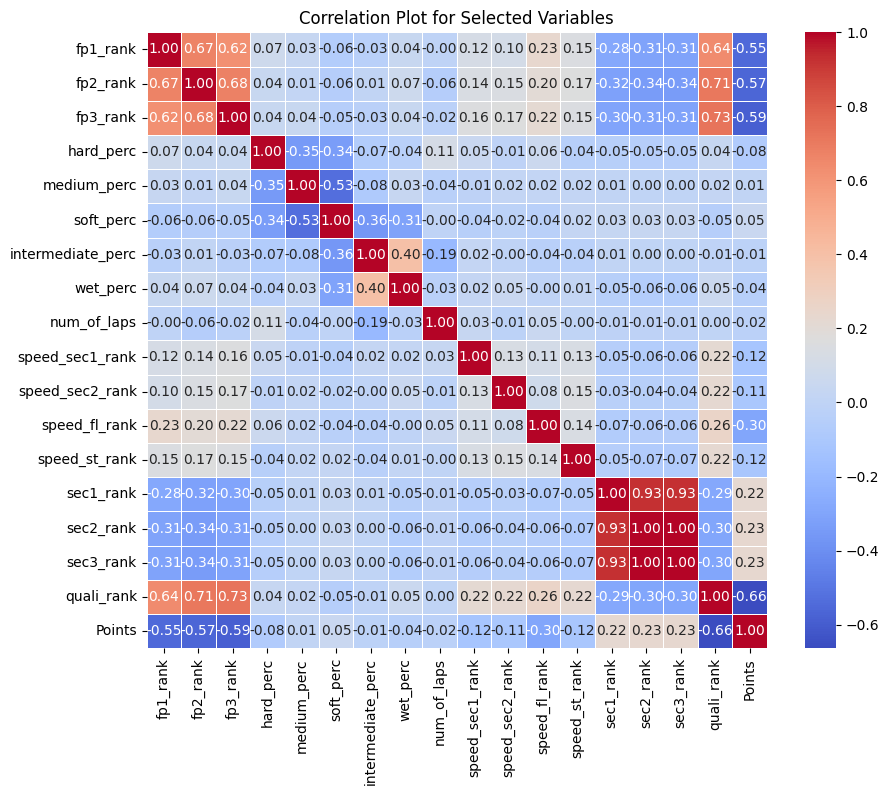

In [6]:
df_analysis = df.drop(columns=['circuit_id', 'year', 'Driver'])
correlation_matrix = df_analysis.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Plot for Selected Variables')
plt.show()

# PCA

In [7]:
df_analysis = df.drop(columns=['circuit_id', 'Driver', 'Points', 'year'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_analysis)

pca = PCA(n_components=len(df_analysis.columns))
principal_components = pca.fit_transform(df_scaled)

# pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(df_analysis.columns))])
# pc_df

components_df = pd.DataFrame(pca.components_, columns=[f'PC{i+1}' for i in range(len(df_analysis.columns))], index=df_analysis.columns)
components_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
fp1_rank,0.350422,0.373450,0.363208,0.042029,0.016688,-0.050055,-0.000054,0.049365,-0.002578,0.108140,0.101971,0.137485,0.116399,-0.359032,-0.372699,-0.372316,0.371288
fp2_rank,0.244541,0.245356,0.264402,-0.006870,0.086203,-0.088355,0.018319,0.029926,-0.024999,0.163213,0.182565,0.214918,0.170247,0.431563,0.435084,0.435323,0.304563
fp3_rank,0.049627,0.032098,0.053943,-0.011019,-0.350402,0.607251,-0.496443,-0.471362,0.139213,0.005436,0.004626,0.059638,0.072598,0.019163,0.027043,0.027757,0.056351
hard_perc,0.012036,-0.008515,-0.019464,0.730332,-0.573421,-0.130808,0.165770,0.124927,0.208776,0.110207,-0.044500,0.076553,-0.104387,0.028375,0.029140,0.029668,-0.002485
medium_perc,0.011753,-0.079607,-0.026905,0.279594,0.471897,-0.400638,-0.441215,-0.271301,0.475615,0.008735,-0.082715,0.158230,-0.047258,-0.020017,-0.013626,-0.015134,-0.044076
soft_perc,-0.246216,-0.216590,-0.192379,-0.067609,-0.019698,0.025586,0.013413,0.111803,0.182411,0.503197,0.498143,0.140307,0.509639,-0.066430,-0.078859,-0.078060,-0.079953
intermediate_perc,0.048204,-0.004912,-0.009379,-0.334932,-0.084654,0.180339,0.120998,0.413589,0.613747,-0.151471,-0.372568,0.339373,0.075418,0.011477,0.010624,0.013637,0.016507
wet_perc,-0.035163,-0.082129,-0.113826,0.110976,0.006443,-0.061117,0.053755,-0.184299,-0.456900,-0.047995,-0.401068,0.642537,0.359150,-0.038527,-0.028181,-0.030882,-0.095512
num_of_laps,0.006046,0.006206,0.019640,-0.130764,0.046829,0.042873,0.054935,-0.088353,-0.030123,0.811412,-0.457191,-0.070795,-0.306301,-0.000476,0.003393,0.006241,0.019542
speed_sec1_rank,0.068162,0.073919,0.027120,0.107391,-0.000599,-0.069378,-0.038375,0.012560,0.057033,-0.010559,-0.418504,-0.586526,0.667167,0.046190,0.020863,0.020122,0.023854


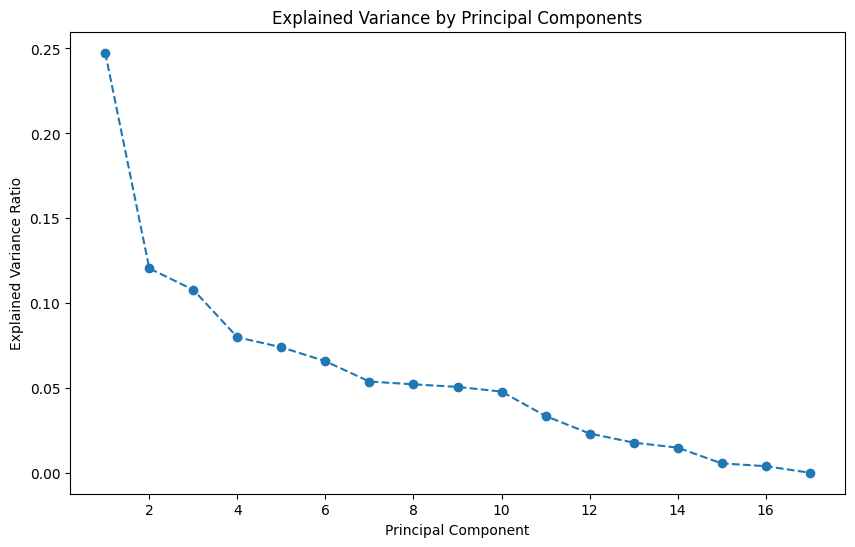

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(df_analysis.columns) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

In [17]:
threshold = 0.7
curr_sum = 0.0
for index, item in enumerate(pca.explained_variance_ratio_):
    if curr_sum + item >= threshold:
        print(f'The first {index + 1} PCA components explain {(curr_sum + item)*100:.2f}% of the variance')
        break
    curr_sum += item

The first 7 PCA components explain 74.96% of the variance


In [19]:
def biplot(pca_scores, components, labels=None, scale=10):
    plt.figure(figsize=(10, 7))
    
    # Plot the PCA scores (the observations in the space of the first two PCs)
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], color='blue', alpha=0.5)
    
    # Plot feature vectors (loadings) with scaling for better visibility
    for i, (component, label) in enumerate(zip(components, labels)):
        plt.arrow(0, 0, component[0] * scale, component[1] * scale, color='red', alpha=0.7, head_width=0.1)
        plt.text(component[0] * scale * 1.15, component[1] * scale * 1.15, label, color='black', ha='center', va='center')

    # Formatting the plot
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Biplot of the First 2 Principal Components')
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.grid(True)
    # plt.savefig("plot.pdf", format="pdf", bbox_inches="tight")
    plt.show()

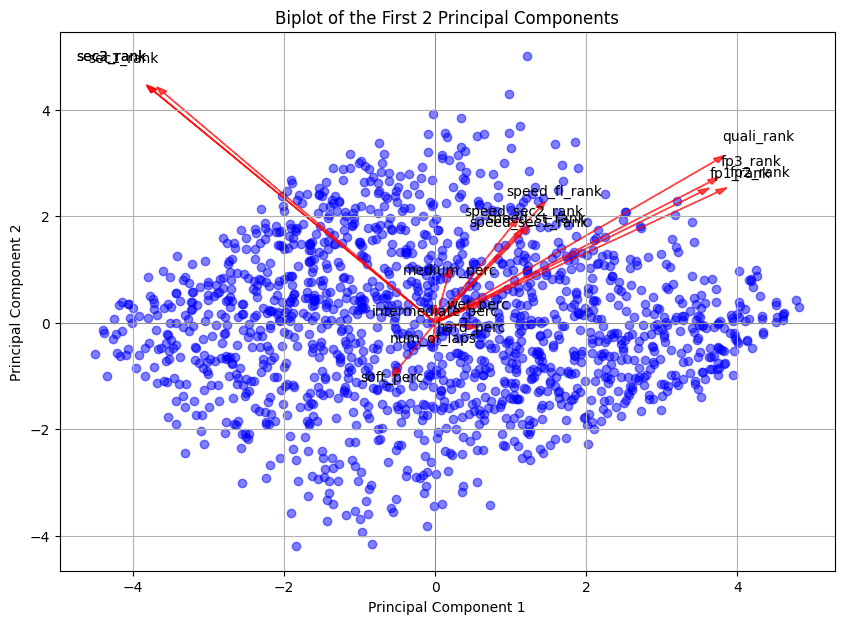

In [20]:
pca2 = PCA(n_components=2)
pca_scores2 = pca2.fit_transform(df_scaled)

biplot(pca_scores2[:, :2], pca2.components_.T, labels=df_analysis.columns)

# ML Models

# PC Regression

In [12]:
Y = df['Points']
X_pca_with_const = sm.add_constant(principal_components)

In [13]:
model = sm.OLS(Y, X_pca_with_const)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     89.24
Date:                Fri, 29 Nov 2024   Prob (F-statistic):          6.74e-213
Time:                        18:41:16   Log-Likelihood:                -4611.3
No. Observations:                1512   AIC:                             9259.
Df Residuals:                    1494   BIC:                             9354.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1690      0.132     39.112      0.000       4.910       5.428
x1            -2.0769      0.064    -32.236      0.000      -2.203      -1.950
x2            -1.6297      0.092    -17.650      0.000      -1.811      -1.449
x3            -0.2923      0.098     -2.995      0.003      -0.484      -0.101
x4            -0.3770      0.113     -3.326      0.001      -0.599      -0.155
x5             0.0521      0.118      0.443      0.658      -0.179       0.283
x6             1.0138      0.125      8.116      0.000       0.769       1.259
x7            -0.5567      0.138     -4.030      0.000      -0.828      -0.286
x8            -0.0206      0.140     -0.147      0.883      -0.296       0.255
x9            -0.0304      0.142     -0.213      0.831      -0.310       0.249
x10            0.3478      0.146      2.376      0.018       0.061       0.635
x11            0.3998      0.175      2.285      0.022       0.057       0.743
x12            0.7537      0.210      3.586      0.000       0.341       1.166
x13            0.2061      0.240      0.860      0.390      -0.264       0.676
x14           -1.6191      0.262     -6.175      0.000      -2.133      -1.105
x15           -0.2204      0.426     -0.517      0.605      -1.056       0.615
x16           -0.4274      0.505     -0.846      0.398      -1.418       0.564
x17           -1.5645      2.464     -0.635      0.526      -6.397       3.268
==============================================================================
Omnibus:                       48.954   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.810
Skew:                           0.326   Prob(JB):                     1.14e-15
Kurtosis:                       3.817   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Linear Regression

In [14]:
X_with_const = sm.add_constant(df_analysis)

In [15]:
model = sm.OLS(Y, X_with_const)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     89.24
Date:                Fri, 29 Nov 2024   Prob (F-statistic):          6.74e-213
Time:                        18:41:18   Log-Likelihood:                -4611.3
No. Observations:                1512   AIC:                             9259.
Df Residuals:                    1494   BIC:                             9354.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                18.4497      2.322      7.944      0.000      13.894      23.005
fp1_rank             -0.1685      0.034     -4.947      0.000      -0.235      -0.102
fp2_rank             -0.1025      0.038     -2.713      0.007      -0.177      -0.028
fp3_rank             -0.2001      0.037     -5.479      0.000      -0.272      -0.128
hard_perc            -3.3587      2.275     -1.476      0.140      -7.822       1.105
medium_perc          -0.4197      2.208     -0.190      0.849      -4.750       3.911
soft_perc            -1.5656      2.100     -0.746      0.456      -5.685       2.554
intermediate_perc    -5.2082      2.869     -1.815      0.070     -10.837       0.420
wet_perc              0.0434      6.137      0.007      0.994     -11.994      12.081
num_of_laps          -0.0175      0.011     -1.593      0.111      -0.039       0.004
speed_sec1_rank       0.0368      0.026      1.400      0.162      -0.015       0.088
speed_sec2_rank       0.0431      0.026      1.663      0.096      -0.008       0.094
speed_fl_rank        -0.2095      0.034     -6.212      0.000      -0.276      -0.143
speed_st_rank         0.0494      0.026      1.896      0.058      -0.002       0.100
sec1_rank            -0.0215      0.062     -0.349      0.727      -0.142       0.099
sec2_rank            -0.1867      0.307     -0.609      0.543      -0.788       0.415
sec3_rank             0.2015      0.306      0.658      0.511      -0.399       0.802
quali_rank           -0.5073      0.039    -12.894      0.000      -0.584      -0.430
==============================================================================
Omnibus:                       48.954   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.810
Skew:                           0.326   Prob(JB):                     1.14e-15
Kurtosis:                       3.817   Cond. No.                     3.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""